In [7]:
import numpy as np
import scipy as sc
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt

<h1>Invertierter Verstärker<h1>

Invert_220k../data/Invert_220k.txt
Invert_150k../data/Invert_150k.txt
Invert_100k../data/Invert_100k.txt
transition index 0:
12
18
transition index 1:
14
22
transition index 2:
14
24


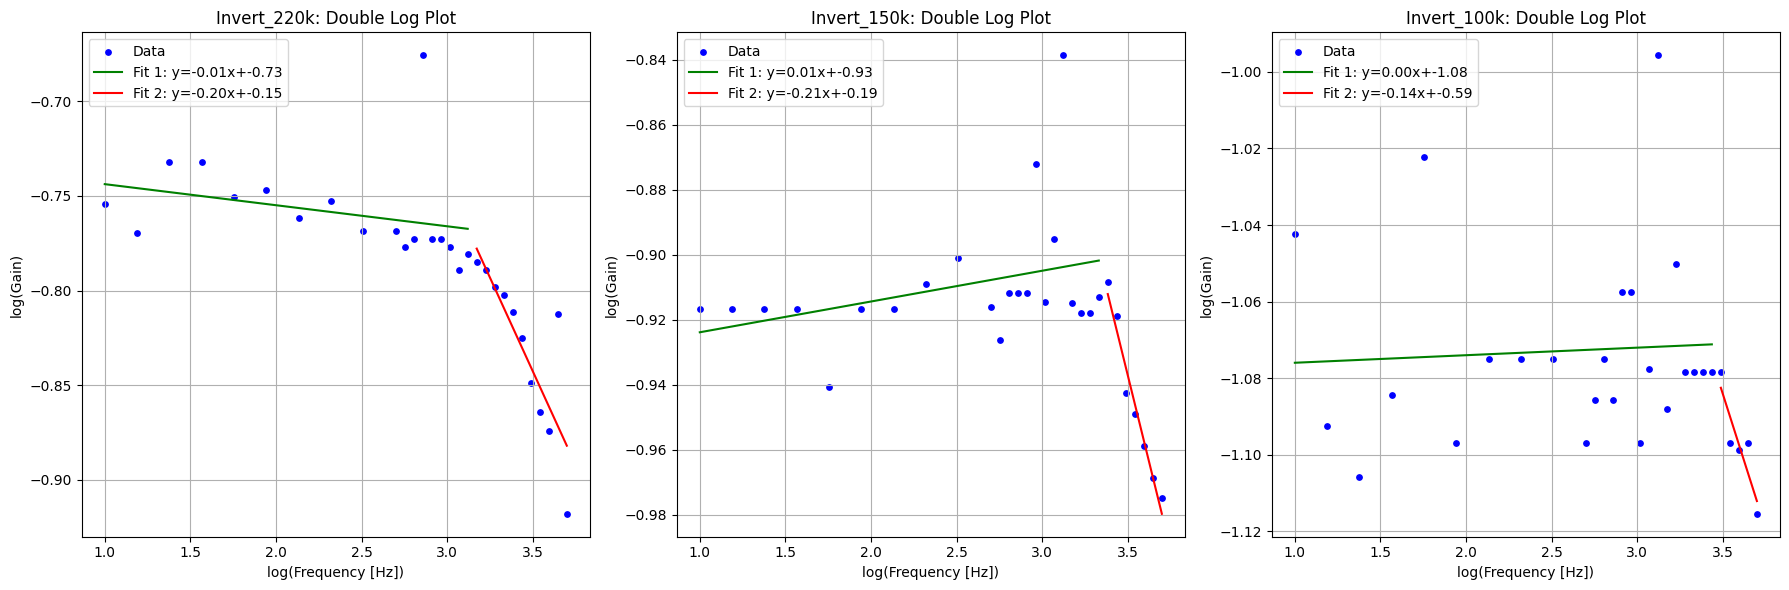

In [ ]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Invert_220k": "../data/Invert_220k.txt",

    "Invert_150k": "../data/Invert_150k.txt",

    "Invert_100k": "../data/Invert_100k.txt"

}



dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data



# Prepare plots

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def modify_cutoff_point(transition_index,i):
    if i == 0:
        transition_index += 6
    if i == 1:
        transition_index += 8
    if i == 2:
        transition_index += 10

    return transition_index

for i, (key, df) in enumerate(dataframes.items()):

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / df['Unamplified_mV'].astype(float)).to_numpy()



    # Log-transform frequency and gain

    log_frequencies = np.log10(frequencies)

    log_gains = np.log10(gains)



    # Adjust transition point selection (using relative slopes for smoother split)

    slopes = np.diff(log_gains) / np.diff(log_frequencies)

    transition_index = np.argmax(slopes < -0.5)  # Find where slope becomes significantly negative
    print("transition index " + str(i) + ":")
    print(transition_index)

    transition_index = modify_cutoff_point(transition_index, i)
    print(transition_index)



    # Fit the first region (constant gain)

    popt1, _ = curve_fit(linear_fit, log_frequencies[:transition_index], log_gains[:transition_index])

    fit1 = linear_fit(log_frequencies[:transition_index], *popt1)



    # Fit the second region (falling gain)

    popt2, _ = curve_fit(linear_fit, log_frequencies[transition_index:], log_gains[transition_index:])

    fit2 = linear_fit(log_frequencies[transition_index:], *popt2)



    # Plot original data

    axes[i].scatter(log_frequencies, log_gains, label="Data", color='blue', s=15)

    # Plot the fits

    axes[i].plot(log_frequencies[:transition_index], fit1, label=f"Fit 1: y={popt1[0]:.2f}x+{popt1[1]:.2f}", color='green')

    axes[i].plot(log_frequencies[transition_index:], fit2, label=f"Fit 2: y={popt2[0]:.2f}x+{popt2[1]:.2f}", color='red')



    # Add labels, title, legend

    axes[i].set_title(f"{key}: Double Log Plot")

    axes[i].set_xlabel("log(Frequency [Hz])")

    axes[i].set_ylabel("log(Gain)")

    axes[i].legend()

    axes[i].grid()



# Adjust layout and show the plots

plt.tight_layout()

plt.show()
